# Final project:
Alejandra Savage Briz

## Abstract

This study draws upon one clean dataset from two Portuguese high schools, capturing comprehensive student achievement data. Sourced from school reports and questionnaires, this rich dataset includes a spectrum of student-related features, including grades, demographic information, social indicators, parental details, and school-related attributes. 

Notably, the focus of this analysis centers on one of the datasets, meticulously cleaned and refined to enhance accessibility and usability, specifically describing students' performance in Mathematics. This dataset provides a detailed lens into the interplay between family dynamics and academic performance, offering a focused exploration of the intricate relationship between familial factors and students' mathematical achievements within the high school landscape.

_______________________________________________________________________________________________________________________________
## Introduction

The early days of high school often create a complex interweaving of academic challenges and evolving family dynamics. This study focuses on one aspect of this intricate tapestry: the relationship between family dynamics and academic performance, particularly emphasizing first-period math grades. Employing regression analysis as a tool, the research aims to dissect how the quality of family relationships influences students' mathematical abilities.

Beyond this primary inquiry, the study acknowledges the multifaceted nature of the family environment. It considers various factors such as family size, parental education levels, family educational support, and the complexities of parental cohabitation status. Even a student's dedication to studying contributes to this textured weave. By accounting for these elements, the analysis seeks to unravel the nuanced impact of family dynamics on academic outcomes.

The overarching goal of this research is to shed light on the diverse influences of family dynamics on the academic journey. By identifying specific dimensions of family dynamics that significantly correlate with, or even predict, math grades, the study aims to establish foundations for impactful interventions and support systems. Imagine educational initiatives aimed at repairing strained relationships, reinforcing supportive elements, and untangling obstacles hindering academic success.

The ultimate ambition of this study is to harness the potential of positive family relationships while mitigating the effects of unfavorable family environments. By comprehending the intricate dance between family dynamics and mathematical performance, we can empower students to navigate their academic paths with confidence, guided by the supportive framework of a well-woven family tapestry.

_______________________________________________________________________________________________________________________________
## Data

The dataset employed in this research, sourced from Kaggle, comprises student achievement data from two separate Portuguese high schools. Gathered via school reports and questionnaires, this extensive dataset encompasses a diverse array of aspects, including student grades, demographic specifics, social indicators, parental details, and school-related attributes. 

The dataset was originally thoroughly cleaned with no missing values focusing on the domain of mathematics. With a total of 396 observations, this study centers on analyzing the **first-period grade** as the _**dependent variable (y)**_, while the _**independent variable**_ is the numeric representation of **Family relationship (ranging from 1 - very bad to 5 - excellent)**.

Additionally, key factors considered in this analysis encompass Family size, parental education levels, family educational support, parental cohabitation status, and study time. Here's a breakdown of the main variables utilized in this study:

- **First Period Grade (y)**: Represents the initial grade achieved in the mathematics course (numeric: from 0 to 20).
- **Family Relationship (Independent Variable)**: Numeric scale assessing the quality of family relationships, ranging from 1 (very bad) to 5 (excellent). It acts as the independent variable, scrutinized for its impact on first-period math grades.
- **Family Size**: Categorized as "Less or equal to 3" or "Greater than 3," indicating the size of the student's family.
- **Parental Education**: Ordinal categorization of both mother's and father's education levels, ranging from "none" to "higher education."
- **Family Educational Support**: Binary assessment (yes or no) of whether the family provides educational support to the student.
- **Parental Cohabitation Status**: Binary categorization indicating whether parents live together or apart.
- **Study Time**: Weekly study time categorized on an ordinal scale from "<2 hours" to ">10 hours," reflecting the amount of time spent studying per week.

These variables were selected due to their potential influence on a student's academic performance in mathematics, aiming to understand how family dynamics and various related factors interrelate with the first-period math grades in high school.

_______________________________________________________________________________________________________________________________
### Setup

#### Importing py_helper_funtions

In [2]:
# Import packages
####################################################
import copy
from typing import List

import numpy as np
import numpy.typing as npt
import pandas as pd
from plotnine import *

####################################################
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start: float, stop: float, by: float, round_n=3) -> list:
    """
    Custom function, used for setting the breaks of plotnine scales.

       Parameters
    ----------
    start : float
        Start of the breaks.
    stop : float
        End of the breaks.
    by : float
        Steps between breaks.
    round_n: int, default=3
        Decimals to round floats in output.
    """
    epsilon = np.finfo("float").eps

    return [
        round(x, round_n) for x in list(np.arange(start, stop + (by - epsilon), by))
    ]


def skew(l: npt.ArrayLike, round_n=3) -> float:
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def knot_ceil(vector: np.array, knot: float) -> np.array:
    vector_copy = copy.deepcopy(vector)
    vector_copy[vector_copy > knot] = knot
    return vector_copy


def lspline(series: pd.Series, knots: List[float]) -> np.array:
    """
    Function to create design matrix to esitmate a piecewise
    linear spline regression.

       Parameters
    ----------
    series : pd.Series
        Your variable in a pandas Series.
    knots : List[float]
        The knots, that result in n + 1 line segments.
    """

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix


def create_calibration_plot(
    data: pd.DataFrame,
    file_name: str,
    prob_var: str,
    actual_var: str,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    """
    Function to create calibration curve.
    Returns calibration curve on a plot.

       Parameters
    ----------
    data : pd.DataFrame
        Your dataframe, containing the actual outcome and
        the predicted probabilities of that outcome
        by a model.
    file_name : str
        Filename to save. NOTE: this is note used for now.
    prob_var : str
        Name of the variable, containin predicted
        probabilities.
    actual_var : str
        Name of the actual outcome variable.
    y_lab: str
        Label on y axis of the plot.
    n_bins : int, default=10
        The number of bins, you would like to create.
        This is because with many values for the predicted probabilities,
        we may have few observations to look at for each value.
    breaks (optional): list or None
        You can speficy the breaks of the plot.
    """

    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    return (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(color=color[0], size=1, alpha=0.7, show_legend=False, na_rm=True)
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )


def poly(x: npt.ArrayLike, degree=1) -> pd.DataFrame:
    """
    Fit polynomial.

    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.

    Parameters
    ----------
    x : npt.ArrayLike
        Data array.
    degree : int, default=1
        Degree of the polynomial.
    """
    d = {}
    for i in range(degree + 1):
        if i == 1:
            d["x"] = x
        else:
            d[f"x**{i}"] = np.power(x, i)
    return pd.DataFrame(d)


def price_diff_by_variables(
    df: pd.DataFrame, factor_var: str, dummy_var: str, factor_lab: str, dummy_lab: str
) -> ggplot:
    """
    Price difference by selected factor and dummy variables.

    This function creates a barplots looking for interactions.
    Used in `ch14-airbnb-prediction.ipynb`.

        Parameters
    ----------
    df : pd.DataFrame
        Your dataframe.
    factor_var : str
        Your factor variable (like room_type).
    dummy_var : str
        The dummy variable you are interested in (like TV).
    factor_lab : str
        The label on the final plot for the `factor_var`.
    dummy_lab : str
        The label on the final plot for the `dummy_var`.
    """

    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    return (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )


import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import rmse


def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator


    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    """

    # Get dependent variable

    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data

    model = smf.ols(formula, data=data).fit()

    rsquared = model.rsquared
    # n_coefficients = model.params.shape[0]
    n_coefficients = (
        model.df_model + 1
    )  # This might differ from model.params.shape[0], because of collinear predictors
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold

    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }


import statsmodels


def point_predict_with_conf_int(
    regression: statsmodels.regression.linear_model.RegressionResultsWrapper,
    new_datapoint: pd.DataFrame,
    interval_precision=0.95,
    round_n=2,
) -> dict:
    """
    Does point prediction and interval prediction for a new datapoint.

        Parameters
    ----------
    regression : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted regression model.
    new_datapoint : pd.DataFrame
        Database containing a new observation.
    interval_precision : float, default=0.95
        Precision of interval prediction.
    round_n: int, default=2
        Decimals to round floats in output.
    """

    summaryframe = regression.get_prediction(new_datapoint).summary_frame(
        alpha=1 - interval_precision
    )

    point_prediction = round(summaryframe["mean"].values[0], round_n)

    conf_int = [
        round(i, round_n)
        for i in summaryframe[["obs_ci_lower", "obs_ci_upper"]].values[0]
    ]

    if round_n == 0:
        point_prediction = int(point_prediction)
        conf_int = [int(i) for i in conf_int]
    else:
        pass

    return {
        "Point prediction": point_prediction,
        f"Prediction Interval ({round(interval_precision*100)}%)": conf_int,
    }


class Error(Exception):
    """Base class for other exceptions"""

    pass


class ConfintError(Error):
    """
    Error raised when a confidence interval
    does not match with required format.
    """

    def __init__(
        self,
        message="Confidence intervals are two numbers, so len(conf_int) must be 2.",
    ):
        self.message = message
        super().__init__(self.message)


def format_confidence_interval(conf_int: List[float], round_n=2) -> str:
    """Format confidence interval.

        Parameters
    ----------
    conf_int: np.array
        Array, consisting upper and upper confidence interval values.
    round_n: int, default=2
        Decimals to round floats in output.
    """
    if len(conf_int) != 2:
        raise ConfintError
    elif round_n == 0:
        return "[" + "–".join([str(int(round(i, round_n))) for i in conf_int]) + "]"
    else:
        return "[" + "–".join([str(round(i, round_n)) for i in conf_int]) + "]"


def create_sample_frame(
    vector: np.array, sample_size: int, n_samples=10000, with_replacement=False, seed=42
) -> List[np.array]:
    """
    Function for a specified number of samples.
    Draws a specified number of observations from a vector, either with or without replacement.
    Returns the matrix of samples.

    Used in `ch05-stock-market-loss-generalize.ipynb`

       Parameters
    ----------
    vector : np.array
        Vector of observations.
    sample_size : int
        Sample size, you want to draw.
        Set it len(vector) for bootstrap sampling.
    n_samples : int, default=10000
        Number of samples.
    with_replacement : bool, default=False
        Whether to perform sampling with or without
        replacement. Set `True` for bootstrap sampling.
    seed : int,default=42
        Random seed for reproducibility.
    """

    rng = np.random.default_rng(seed)
    sample_frame = np.zeros((n_samples, sample_size))
    for i in range(n_samples):
        sample_frame[i] = rng.choice(vector, size=sample_size, replace=with_replacement)

    return sample_frame


def add_margin(ax, x=0.05, y=0.05) -> None:
    """
    This will, by default, add 5% to the x and y margins to matplotlib plots.
    You can customise this using the x and y arguments when you call it.

       Parameters
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        Vector of observations.
    x : float,default=0.05
        Margin to add for x axis.
    y : float,default=0.05
        Margin to add for x axis.
    """

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmargin = (xlim[1] - xlim[0]) * x
    ymargin = (ylim[1] - ylim[0]) * y

    ax.set_xlim(xlim[0] - xmargin, xlim[1] + xmargin)
    ax.set_ylim(ylim[0] - ymargin, ylim[1] + ymargin)

#### Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
import sys
import warnings

from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

_______________________________________________________________________________________________________________________________
### Loading dataset directly from Github

In [4]:
# Github repository URL
url="https://raw.githubusercontent.com/Alejandra-savagebriz/DA2/main/student_math_clean.csv"

# Read CSV file from GitHub URL
df = pd.read_csv(url)

In [5]:
# Print DataFrame to validate the correct data load
df

,student_id,school,sex,age,address_type,family_size,parent_status,mother_education,father_education,mother_job,...,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
0,1,GP,F,18,Urban,Greater than 3,Apart,higher education,higher education,at_home,...,4,3,4,1,1,3,6,5,6,6
1,2,GP,F,17,Urban,Greater than 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,5,3,3,1,1,3,4,5,5,6
2,3,GP,F,15,Urban,Less than or equal to 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,4,3,2,2,3,3,10,7,8,10
3,4,GP,F,15,Urban,Greater than 3,Living together,higher education,5th to 9th grade,health,...,3,2,2,1,1,5,2,15,14,15
4,5,GP,F,16,Urban,Greater than 3,Living together,secondary education,secondary education,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,391,MS,M,20,Urban,Less than or equal to 3,Apart,5th to 9th grade,5th to 9th grade,services,...,5,5,4,4,5,4,11,9,9,9
391,392,MS,M,17,Urban,Less than or equal to 3,Living together,secondary education,primary education (4th grade),services,...,2,4,5,3,4,2,3,14,16,16
392,393,MS,M,21,Rural,Greater than 3,Living together,primary education (4th grade),primary education (4th grade),other,...,5,5,3,3,3,3,3,10,8,7
393,394,MS,M,18,Rural,Less than or equal to 3,Living together,secondary education,5th to 9th grade,services,...,4,4,1,3,4,5,0,11,12,10


In [6]:
# Checking if there are missing values for each variable

nulls = df.isnull().sum()
print(f"The total number of null values in tha data is: \n{nulls}")

# Since there are no missing values, there is no need to drop them

The total number of null values in tha data is: 
student_id               0
school                   0
sex                      0
age                      0
address_type             0
family_size              0
parent_status            0
mother_education         0
father_education         0
mother_job               0
father_job               0
school_choice_reason     0
guardian                 0
travel_time              0
study_time               0
class_failures           0
school_support           0
family_support           0
extra_paid_classes       0
activities               0
nursery_school           0
higher_ed                0
internet_access          0
romantic_relationship    0
family_relationship      0
free_time                0
social                   0
weekday_alcohol          0
weekend_alcohol          0
health                   0
absences                 0
grade_1                  0
grade_2                  0
final_grade              0
dtype: int64


There are no missing values in the DataFrame

In [7]:
# Checking dataFrame columns
df.columns

Index(['student_id', 'school', 'sex', 'age', 'address_type', 'family_size',
       'parent_status', 'mother_education', 'father_education', 'mother_job',
       'father_job', 'school_choice_reason', 'guardian', 'travel_time',
       'study_time', 'class_failures', 'school_support', 'family_support',
       'extra_paid_classes', 'activities', 'nursery_school', 'higher_ed',
       'internet_access', 'romantic_relationship', 'family_relationship',
       'free_time', 'social', 'weekday_alcohol', 'weekend_alcohol', 'health',
       'absences', 'grade_1', 'grade_2', 'final_grade'],
      dtype='object')

_______________________________________________________________________________________________________________________________
### Descriptive statistics

In [8]:
df.describe()

,student_id,age,class_failures,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,198.000000,16.696203,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,114.170924,1.276043,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,1.000000,15.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,99.500000,16.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,198.000000,17.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,296.500000,18.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,395.000000,22.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


Based on the previous table:
* Average student age is 17 years old.
* Average student has had 0.33 class failures.
* About 33.4% of students have a family relationship that is rated as "poor."
* The average student has 3.94 hours of free time per day.
* An average student scores 3.24 on a social engagement scale.
* 14.8% of students report drinking alcohol on weekdays.
* 2.29% of students report drinking alcohol on weekends.
* Average student reports having good health.
* Average student has 3.55 absences from school.
* Average final grade is 10.42.

_______________________________________________________________________________________________________________________________
### Dummy variable creation

#### Family_relationship

The 'family_relationship' variable measures from 1-5 the quality of the relationship among parents and child.
1 corresponding to worst and 5 to best.

In [9]:
df["family_relationship"].value_counts()

family_relationship
4    195
5    106
3     68
2     18
1      8
Name: count, dtype: int64

#### Parent status

The 'parent_status' variable has only two options: Living together or Apart

In [10]:
df["parent_status"].value_counts()

parent_status
Living together    354
Apart               41
Name: count, dtype: int64

Creating dummy variables for the 2 types of status:

In [11]:
df['parent_status_apart'] = (df['parent_status'] != "Living together").astype(int)
# Dropping the original 'family_size' column
df.drop('parent_status', axis=1, inplace=True)

#### Family size

The 'family_size' variable has only two options: Greater than 3 or Less than or equal to 3

In [12]:
df['family_size_greater_than_3'] = (df['family_size'] != "Less than or equal to 3").astype(int)
# Dropping the original 'family_size' column
df.drop('family_size', axis=1, inplace=True)

#### Parents Education

The 'mother_education' and 'father_education' variables have the following options:
* Higher education
* 5th to 9th grade
* Secondary education
* Primary education (4th grade)
* None

##### Mother Education

In [14]:
df["mother_education"].value_counts()

mother_education
higher education                 131
5th to 9th grade                 103
secondary education               99
primary education (4th grade)     59
none                               3
Name: count, dtype: int64

In [15]:
df['mother_education_higher_education'] = (df['mother_education'] == "higher education").astype(int)
df['mother_education_5th_to_9th_grade'] = (df['mother_education'] == "5th to 9th grade").astype(int)
df['mother_education_secondary_education'] = (df['mother_education'] == "secondary education").astype(int)
df.drop('mother_education', axis=1, inplace=True)

##### Father Education

In [16]:
df["father_education"].value_counts()

father_education
5th to 9th grade                 115
secondary education              100
higher education                  96
primary education (4th grade)     82
none                               2
Name: count, dtype: int64

In [17]:
df['father_education_higher_education'] = (df['father_education'] == "higher education").astype(int)
df['father_education_5th_to_9th_grade'] = (df['father_education'] == "5th to 9th grade").astype(int)
df['father_education_secondary_education'] = (df['father_education'] == "secondary education").astype(int)
df.drop('father_education', axis=1, inplace=True)

#### Study Time

In [18]:
df["study_time"].value_counts()

study_time
2 to 5 hours     198
<2 hours         105
5 to 10 hours     65
>10 hours         27
Name: count, dtype: int64

In [19]:
df['study_time_2_to_5_hours'] = (df['study_time'] == '2 to 5 hours').astype(int)
df['study_time_5_to_10_hours'] = (df['study_time'] == '5 to 10 hours').astype(int)
df['study_time_more_than_10_hours'] = (df['study_time'] == '>10 hours').astype(int)
df.drop('study_time',axis=1,inplace=True)

_______________________________________________________________________________________________________________________________
### Outlier analysis

After checking the descriptive statistics table, 

## Models

### Model 1: Simple Regression between Final Grade and Family Relationship
$Final Grade = \beta_0 + \beta_1\times FamilyRelationship$


This simple linear regression model is used to examine the potential connection between family relationship quality and students' final grades.

In [20]:
# X is the independent variable, y is the dependent variable
import statsmodels.api as sm
X = df['family_relationship']
y = df['final_grade']

X = sm.add_constant(X)  # Adding a constant (intercept) to the model
model1 = sm.OLS(y, X).fit()  # Ordinary Least Squares regression
#print(model1.summary())  # Display regression summary

# use robust std
reg = smf.ols(formula="final_grade~family_relationship", data=df).fit(cov_type="HC1")
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            final_grade   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.9299
Date:                Sat, 23 Dec 2023   Prob (F-statistic):              0.335
Time:                        15:21:35   Log-Likelihood:                -1160.7
No. Observations:                 395   AIC:                             2325.
Df Residuals:                     393   BIC:                             2333.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.3800      1.104      8.500      0.000       7.217      11.543
family_relationship     0.2624      0.272      0.964      0.335      -0.271       0.796
==============================================================================
Omnibus:                       31.923   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.301
Skew:                          -0.729   Prob(JB):                     7.95e-09
Kurtosis:                       3.375   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

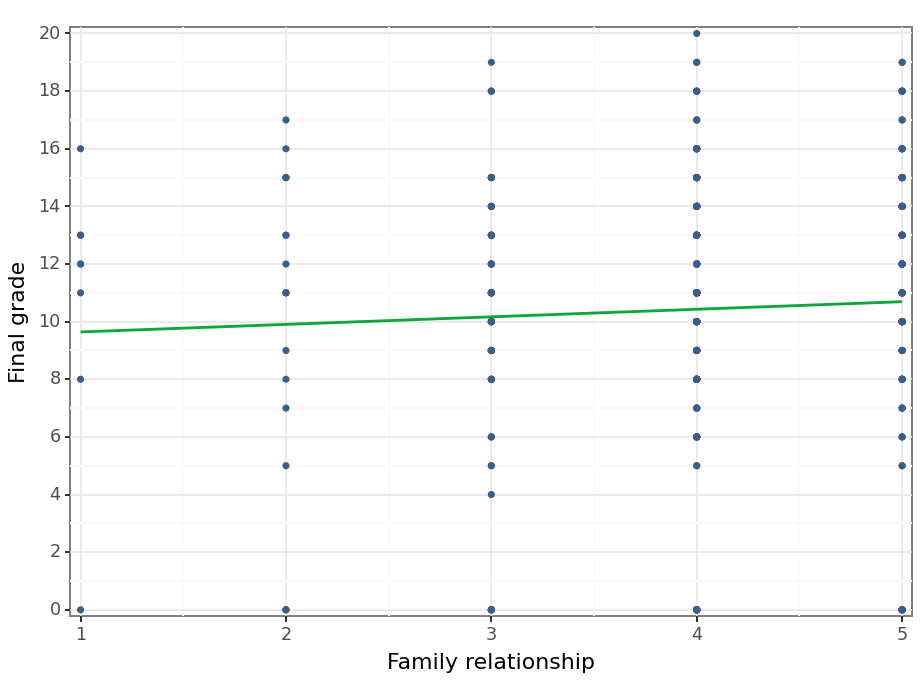

<Figure Size: (460 x 345)>

In [21]:
from plotnine import ggplot, aes, geom_point, geom_smooth, coord_cartesian, scale_x_continuous, scale_y_continuous, labs, theme_bw

# Assuming 'df' is your DataFrame and 'color' is defined
(
    ggplot(df, aes(x="family_relationship", y="final_grade"))
    + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="lm", color=color[1], se=False, size=0.8, linetype="solid")
    + coord_cartesian(xlim=(1, 5), ylim=(0, 20))  # Adjust limits according to your data
    + scale_x_continuous(expand=(0.01, 0.01), breaks=list(range(1, 6)))  # Assuming x is categorical
    + scale_y_continuous(expand=(0.01, 0.01), breaks=list(range(0, 21, 2)))  # Assuming y range is 0-20
    + labs(x="Family relationship", y="Final grade")
    + theme_bw()
)


### Interpretation
* The **p-value** for the _family_relationship_ coefficient is 0.309, which is much higher than the common significance level of 0.05. This means we cannot conclude that there's a statistically significant relationship between family relationship quality and final grades.


* The **R-squared value** is 0.003, indicating that the model explains only a tiny fraction (0.3%) of the variation in final grades.

* The **intercept** of 9.38 represents the predicted final grade when the family relationship quality is 0 (very bad), yet there should be more factors to analyze. 

* The **family_relationship** coefficient of 0.2624 suggests that for every one-unit increase in family relationship quality (on the 1-5 scale), the predicted final grade would increase by 0.2624 points, holding all other factors constant. But again, this association is not statistically significant.

$Final Grade = 9.3800 + 0.2624 * Family Relationship$


Therefore, while the positive coefficient implies a potential link, its significance and the model's overall weakness prevent us from definitively concluding that family relationships significantly impact student success. More comprehensive models incorporating other relevant factors like study habits, individual characteristics, and school environment are crucial to unravel the complex web of influences on academic achievement.

Based on this model, we cannot confidently say that family relationship quality has a significant impact on final grades within this data since it only considers family relationship quality. Other variables, such as study time, individual student characteristics, and school-related factors, might also influence final grades.